# Goat Detection training

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets, models
from tqdm import tqdm
import cv2
from os import listdir
from model import GoatDetector


In [2]:
class GoatDataset(Dataset):
    def __init__(self, size=64, cifar10_limit=500):
        self.size = size
        self.transform = transforms.ToTensor()
        self.images = []

        goat_im_names = listdir("./data/goats/")
        self.num_goats = len(goat_im_names)
        for im_name in goat_im_names:
            # print(im_name)
            self.images.append(self.load_image("./data/goats/"+im_name))
        
        nongoat_im_names = listdir("./data/nongoats/")
        for im_name in nongoat_im_names:
            self.images.append(self.load_image("./data/nongoats/"+im_name))

        self.cifar10 = datasets.CIFAR10("./data/",                                 
                              train=True, 
                              transform=transforms.Compose([
                                        transforms.Resize(self.size),
                                        transforms.ToTensor()]), 
                              download=True)
        
        self.total_ims = len(self.images) + cifar10_limit

    def load_image(self, path):
        im = cv2.imread(path)[:, :, ::-1]
        im = cv2.resize(im, (self.size, self.size))
        im = self.transform(im)
        return im


    def __getitem__(self, index):
        is_goat = index<self.num_goats
        if index < len(self.images):
            return self.images[index], torch.tensor(is_goat).float()
        return self.cifar10[index-len(self.images)][0], torch.tensor(is_goat).float()

    def __len__(self):
        return self.total_ims


In [3]:
dataset = GoatDataset(cifar10_limit=500)
batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_size = len(train_indices)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_size = len(val_indices)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


Files already downloaded and verified


In [4]:
bne = nn.BCELoss()
model = GoatDetector()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)

In [5]:
accuracies = []
losses = []

In [6]:
epochs = 10
for epoch in range(epochs):

  loop = tqdm(total=len(train_loader), position=0)
  total_loss= 0
  total_accuracy = 0 

  for i, (image, label) in enumerate(train_loader):
    image, label = image.cuda(), label.cuda()
    optimizer.zero_grad()

    out = model(image)

    loss = bne(out, label)
    loss.backward()
    optimizer.step()
    total_loss+= loss.item()

    preds = (out >= 0.5).float().squeeze(1)
    accuracy = (preds == label).sum().item() / len(label)
    accuracies.append(accuracy)

    total_accuracy += accuracy
    losses.append(loss.item())

    loop.set_description('epoch:{:d} loss:{:.4f} accuracy:{:.2f}'.format(epoch, total_loss/(i+1), total_accuracy/(i+1)))
    loop.update(1)
  loop.close()

  total_correct = 0
  positives = 0
  for i, (image, label) in enumerate(validation_loader):
    image, label = image.cuda(), label.cuda()
    out = model(image)
    preds = (out >= 0.5).float().squeeze(1)
    total_correct += (preds == label).sum().item()
    positives += label.sum().item()
  print(f"\nValidation accuracy: {total_correct/validation_size:.2f} ({positives/validation_size:.2f} positives)")


epoch:1 loss:0.5332 accuracy:0.69:   2%|▏         | 1/61 [00:00<00:07,  8.15it/s]
Validation accuracy: 0.77 (0.25 positives)
epoch:2 loss:0.0722 accuracy:1.00:   2%|▏         | 1/61 [00:00<00:06,  8.72it/s]
Validation accuracy: 0.80 (0.25 positives)
epoch:3 loss:0.2426 accuracy:1.00:   2%|▏         | 1/61 [00:00<00:07,  8.22it/s]
Validation accuracy: 0.79 (0.25 positives)
epoch:4 loss:0.2773 accuracy:0.88:   2%|▏         | 1/61 [00:00<00:06,  8.76it/s]
Validation accuracy: 0.82 (0.25 positives)
epoch:5 loss:0.1286 accuracy:0.94:   2%|▏         | 1/61 [00:00<00:07,  8.53it/s]
Validation accuracy: 0.80 (0.25 positives)
epoch:6 loss:0.1884 accuracy:0.88:   2%|▏         | 1/61 [00:00<00:07,  8.50it/s]
Validation accuracy: 0.81 (0.25 positives)
epoch:7 loss:0.0309 accuracy:1.00:   2%|▏         | 1/61 [00:00<00:06,  8.68it/s]
Validation accuracy: 0.84 (0.25 positives)
epoch:8 loss:0.0480 accuracy:1.00:   2%|▏         | 1/61 [00:00<00:07,  8.43it/s]
Validation accuracy: 0.83 (0.25 positives)


Accuracy


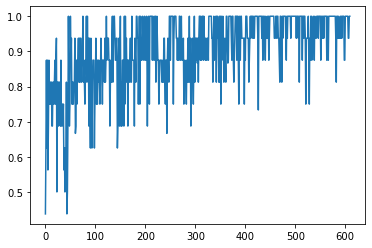

Loss


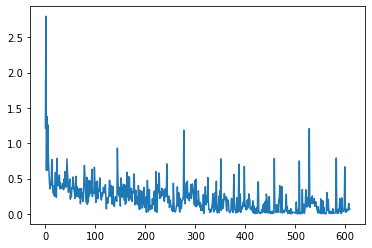

In [7]:
print("Accuracy")
plt.plot(accuracies)
plt.show()

print("Loss")
plt.plot(losses)
plt.show()

In [9]:
torch.save(model.state_dict(), "./saved_models/simple")